In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 9 (Query Translation - HyDE)"

# Query translation

![](images/query-translation-01.png)

# Part 9: Query Translation - HyDE

![](images/09-hyde.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BKNeTP2oDtNaIUx3bmnWgmT3W7cEJ', 'finish_reason': 'stop', 'logprobs': None}, id='run-aa7ff30f-35ce-4a3a-98eb-863a918476d3-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

1

In [9]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

## Split documents

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

66

## Store documents

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

In [13]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(66, 66)

## RAG

In [14]:
from typing import Annotated, TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
import numpy as np

In [15]:
hyde_prompt_template = """Please write a passage to answer the question
Question: {question}
Passage:"""
print(hyde_prompt_template)

Please write a passage to answer the question
Question: {question}
Passage:


In [16]:
rag_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}
"""
print(rag_prompt_template)

Answer the following question based on this context:

{context}

Question: {question}



In [17]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [18]:
query = "What is task decomposition for LLM agents?"

In [19]:
class State(TypedDict):
    question: str
    generated_documents: list[str]
    hyde_embeddings: np.ndarray
    context: list[Document]
    answer: str

In [20]:
def generate_documents(state: State, config: RunnableConfig) -> list[Document]:
    generated_documents_count = config['configurable'].get("generated_documents_count", 3)
    
    hyde_prompt = hyde_prompt_template.format(
        question=state["question"]
    )
    generated_documents = llm.batch([hyde_prompt] * generated_documents_count)
    
    return {"generated_documents": [document.content for document in generated_documents]}


def calculate_hyde_embeddings(state: State):
    question_embeddings = np.array(embeddings.embed_query(state['question']))
    generated_documents_embeddings = np.array(embeddings.embed_documents(state['generated_documents']))
    hyde_embeddings = np.vstack([question_embeddings, generated_documents_embeddings]).mean(axis=0)
    return {"hyde_embeddings": list(hyde_embeddings)}


def get_relevant_documents(state: State):
    documents = vectorstore.similarity_search_by_vector(state["hyde_embeddings"])
    return {"context": documents}


def generate_answer(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        context=docs_content,
        question=state["question"]
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}

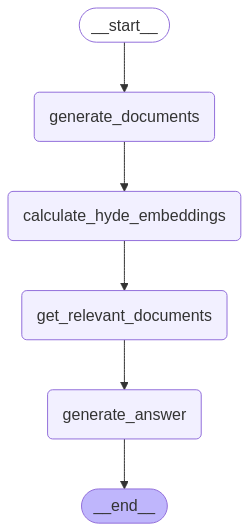

In [21]:
graph_builder = StateGraph(State)

graph_builder.add_node("generate_documents", generate_documents)
graph_builder.add_node("calculate_hyde_embeddings", calculate_hyde_embeddings)
graph_builder.add_node("get_relevant_documents", get_relevant_documents)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "generate_documents")
graph_builder.add_edge("generate_documents", "calculate_hyde_embeddings")
graph_builder.add_edge("calculate_hyde_embeddings", "get_relevant_documents")
graph_builder.add_edge("get_relevant_documents", "generate_answer")
graph_builder.add_edge("generate_answer", END)
graph = graph_builder.compile()
graph

In [22]:
print(query)

response = graph.invoke({"question": query})

display(Pretty(response, max_depth=2, max_length=20))
display(Markdown(response["answer"]))

What is task decomposition for LLM agents?


{
    'question': 'What is task decomposition for LLM agents?',
    'generated_documents': [
        'Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex 
tasks into smaller, more manageable sub-tasks that a language model can handle effectively. This approach allows 
LLMs to tackle intricate problems by addressing each component step-by-step, thus enhancing their ability to 
generate coherent and contextually relevant responses. \n\nIn practice, task decomposition involves analyzing a 
given query or task to identify its core elements and dependencies. For instance, a user might ask an LLM to 
generate a business plan. Instead of processing the entire request at once, the model can decompose the task into 
several sub-tasks, such as market analysis, financial projections, and marketing strategies. By sequentially 
addressing each sub-task, the LLM can produce more detailed and structured outputs.\n\nMoreover, task decomposition
assists in improving the overall accuracy and relevance of the responses by allowing the model to focus on one 
aspect at a time. It also enables the integration of various reasoning capabilities, as the LLM can apply different
logic patterns and knowledge areas while working through each component of the overall task. This method ultimately
enhances the effectiveness and usability of LLM agents in various applications, including writing, problem-solving,
and decision-making.',
        "Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex 
tasks into smaller, manageable components that can be more easily understood and executed by the agent. This 
approach is particularly useful when dealing with intricate problems that require multiple steps or diverse 
knowledge areas. By deconstructing a task into its fundamental parts, LLM agents can systematically address each 
component, leveraging their language understanding to generate more accurate and coherent responses.\n\nFor 
example, if tasked with writing a research paper, an LLM agent might first decompose the assignment into several 
key stages: topic selection, research, outlining, drafting, and revision. The agent can then focus on each stage 
sequentially or in parallel, ensuring that it adequately addresses each aspect of the task. This method enhances 
the efficiency and effectiveness of the agent's performance, as it allows for targeted responses and minimizes the 
risk of oversight or errors.\n\nAdditionally, task decomposition can facilitate collaboration among multiple LLM 
agents, with each agent specializing in different parts of the overall task. This division of labor can lead to 
improved outcomes, as it allows for the pooling of knowledge and capabilities. Overall, task decomposition is a 
critical strategy for optimizing the problem-solving abilities of LLM agents, enabling them to take on complex 
challenges with greater precision and clarity.",
        'Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex 
tasks into smaller, more manageable sub-tasks or components. This approach leverages the capabilities of LLMs to 
handle specific, well-defined instructions, which enhances their overall efficiency and effectiveness in generating
responses or performing designated actions. By segmenting a larger task into simpler parts, LLM agents can 
systematically address each element, ensuring that all aspects are thoroughly executed and reducing the risk of 
errors.\n\nFor instance, if a user requires an LLM to draft a comprehensive report, the agent might first decompose
this task into several key stages: conducting research, outlining the report structure, writing individual 
sections, and finally, editing and revising the content. This step-by-step breakdown allows the agent to focus on 
one aspect at a time, making it easier to ensure the quality and coherence of the final output. \n\nFur

Task decomposition for LLM (large language model) agents refers to the process of breaking down complex tasks into 
smaller, manageable subgoals. This method allows the agent to systematically address each subgoal step by step,    
enhancing its ability to perform complicated tasks more efficiently. The technique, known as Chain of Thought      
(CoT), instructs the model to "think step by step," leading to improved performance and a clearer interpretation of
the model's reasoning process. By transforming larger tasks into simpler components, task decomposition facilitates
the agent's planning and execution capabilities.

In [23]:
print(query)

config = {
    "configurable": {
        "generated_documents_count": 5,   
    }
}
response = graph.invoke({"question": query}, config=config)

display(Pretty(response, max_depth=2, max_length=20))
display(Markdown(response["answer"]))

What is task decomposition for LLM agents?


{
    'question': 'What is task decomposition for LLM agents?',
    'generated_documents': [
        'Task decomposition for large language model (LLM) agents is the process of breaking down complex tasks 
into smaller, more manageable subtasks that can be processed more efficiently. This approach enables LLMs to tackle
intricate problems by simplifying them into a series of steps that can be addressed sequentially or in parallel. 
Each subtask focuses on a specific aspect of the overall task, making it easier for the LLM to generate accurate 
and relevant responses.\n\nIn practice, task decomposition involves identifying the different components of a given
task, such as information gathering, analysis, and synthesis. By segmenting these components, LLM agents can 
operate with greater precision, allowing them to leverage their strengths in natural language understanding and 
generation. Furthermore, task decomposition can facilitate better resource management, as LLMs can prioritize and 
optimize their processing efforts based on the requirements of each subtask.\n\nThis methodology not only enhances 
the efficiency and effectiveness of LLM agents but also allows them to be applied to a wider range of applications.
By breaking down tasks, LLMs become more adept at handling diverse challenges in fields such as customer support, 
content creation, and data analysis, ultimately leading to improved user experiences and outcomes.',
        'Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down a complex 
task into smaller, manageable sub-tasks that can be addressed sequentially or independently. This approach 
leverages the strengths of LLMs in natural language understanding and generation by allowing them to handle 
specific components of a larger problem more effectively. Each sub-task can be formulated as a distinct query or 
instruction, enabling the LLM to focus on providing targeted responses or solutions rather than attempting to 
tackle the entire task in one go. \n\nFor instance, in a scenario where an LLM is tasked with organizing a travel 
itinerary, task decomposition might involve separating the process into distinct segments such as researching 
destinations, booking accommodations, and planning activities. By addressing each of these components individually,
the LLM can optimize its performance, ensure thoroughness, and enhance the overall quality of the output. Moreover,
task decomposition facilitates better collaboration between multiple LLM agents or other AI systems, as they can 
work on different parts of the task concurrently, leading to more efficient problem-solving and project completion.
Overall, task decomposition is a valuable strategy for maximizing the potential of LLMs, allowing them to exhibit 
greater proficiency in addressing complex, multifaceted challenges.',
        'Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex 
tasks or problems into smaller, more manageable sub-tasks that can be individually addressed. This approach 
facilitates more effective problem-solving and enhances the model\'s ability to provide coherent and contextually 
relevant responses.\n\nIn practical terms, task decomposition involves analyzing a given task to identify its key 
components and relationships. For instance, if the task is to "plan a vacation," it can be decomposed into 
sub-tasks such as "choose a destination," "budget for the trip," "create an itinerary," and "book accommodations." 
By tackling these sub-tasks sequentially or in parallel, the LLM can generate more accurate and detailed outputs, 
improving the overall quality of the response.\n\nFurthermore, task decomposition enables LLM agents to work 
through intricate scenarios more systematically. It can leverage its linguistic and contextual understanding to 
address each sub-task based on the information available. This approach not only enhances the LLM\'s e

Task decomposition for LLM (large language model) agents is the process by which an agent breaks down large,       
complex tasks into smaller, more manageable subgoals. This method allows the agent to handle complicated tasks     
efficiently by transforming them into a series of simpler steps. By employing techniques such as Chain of Thought  
(CoT), the model is encouraged to "think step by step," enabling it to utilize its computational power effectively 
and providing insights into its reasoning process. This approach enhances the overall model performance by         
facilitating clearer planning and execution of tasks.